In [1]:
import pandas as pd
import numpy as np

num_cols = [
    "loan_amount", "loan_to_value_ratio", "interest_rate", "rate_spread",
    "total_loan_costs", "total_points_and_fees", "origination_charges",
    "discount_points", "lender_credits", "loan_term",
    "prepayment_penalty_term", "intro_rate_period", "property_value",
    "total_units", "multifamily_affordable_units", "income",
    "tract_population", "tract_minority_population_percent",
    "ffiec_msa_md_median_family_income", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    "tract_median_age_of_housing_units"
]

cat_cols = [
    "lei", "derived_msa-md", "state_code", "county_code",
    "census_tract", "conforming_loan_limit", "derived_loan_product_type",
    "derived_dwelling_category", "derived_ethnicity", "derived_race",
    "derived_sex", "action_taken", "purchaser_type", "preapproval",
    "loan_type", "loan_purpose", "lien_status", "reverse_mortgage",
    "open-end_line_of_credit", "business_or_commercial_purpose",
    "construction_method", "occupancy_type",
    "manufactured_home_secured_property_type",
    "manufactured_home_land_property_interest",
    "applicant_credit_score_type", "co-applicant_credit_score_type",
    "applicant_ethnicity_observed", "co-applicant_ethnicity_observed",
    "applicant_race_observed", "co-applicant_race_observed",
    "applicant_sex", "co-applicant_sex", "applicant_sex_observed",
    "co-applicant_sex_observed", "applicant_age_above_62",
    "co-applicant_age_above_62", "submission_of_application",
    "initially_payable_to_institution",
    "negative_amortization", "interest_only_payment",
    "balloon_payment", "other_nonamortizing_features"
]

multi_slot_cols = [
    "applicant_ethnicity-1","applicant_ethnicity-2","applicant_ethnicity-3",
    "applicant_ethnicity-4","applicant_ethnicity-5",
    "co-applicant_ethnicity-1","co-applicant_ethnicity-2",
    "co-applicant_ethnicity-3","co-applicant_ethnicity-4",
    "co-applicant_ethnicity-5",
    "applicant_race-1","applicant_race-2","applicant_race-3",
    "applicant_race-4","applicant_race-5",
    "co-applicant_race-1","co-applicant_race-2",
    "co-applicant_race-3","co-applicant_race-4","co-applicant_race-5",
    "aus-1","aus-2","aus-3","aus-4","aus-5",
    "denial_reason-1","denial_reason-2","denial_reason-3","denial_reason-4"
]

df = pd.read_csv("pwc_dataset.csv", sep=';')

print(df.shape)
print(df.info())
print(df.head())

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)



desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T



for col in ["action_taken", "loan_purpose", "loan_type",
            "derived_race", "derived_ethnicity", "derived_sex"]:
    print(col, df[col].value_counts(dropna=False).head(20))

for col in num_cols:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)




print("\n=== DEBUG NUMERIC CONVERSION ERRORS ===")

# Keep track of rows to drop
rows_to_drop = set()

for col in num_cols:
    for idx, val in df[col].items():
        try:
            # Replace comma with dot and try conversion
            float(str(val).replace(',', '.'))
        except Exception:
            print(f"[ERROR] Column '{col}', Row {idx}, Bad Value: '{val}'")
            rows_to_drop.add(idx)

# Drop all offending rows at once
if rows_to_drop:
    print(f"\n[DROPPING] {len(rows_to_drop)} rows due to invalid numeric values.")
    df = df.drop(index=rows_to_drop)

print(f"Rows remaining after drop: {df.shape[0]}")


#corr = df[num_cols].corr()



C:\Users\JAVI\AppData\Local\Temp\ipykernel_23928\4098596400.py:51: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pwc_dataset.csv", sep=';')


(200000, 99)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             200000 non-null  int64  
 1   lei                                       200000 non-null  object 
 2   derived_msa-md                            200000 non-null  int64  
 3   state_code                                198617 non-null  object 
 4   county_code                               198627 non-null  float64
 5   census_tract                              198627 non-null  float64
 6   conforming_loan_limit                     199710 non-null  object 
 7   derived_loan_product_type                 200000 non-null  object 
 8   derived_dwelling_category                 200000 non-null  object 
 9   derived_ethnicity                         200000 non-null  object 
 10  derived

# Análisis estadístico de los datos
Objetivo: detectar valores fuera de lo normal

In [2]:
print("\n=== OUTLIER DETECTION (IQR METHOD) ===")

# Columns to exclude from outlier detection
excluded_cols = {}

# Prepare storage
outlier_positions = []
total_rows = df.shape[0]

# Filter numeric columns to analyze
cols_to_check = [c for c in num_cols if c not in excluded_cols]

for col in cols_to_check:
    # Convert safely to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')
    series = df[col].dropna()

    if series.empty:
        continue

    # Calculate IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df[mask][col]

    for idx, val in outliers.items():
        outlier_positions.append((idx, col, val))
        #print(f"[OUTLIER] Row {idx}, Column '{col}', Value: {val}")

# Summary
print("\n=== OUTLIER SUMMARY ===")
print(f"Total rows analyzed: {total_rows}")
print(f"Total outliers detected: {len(outlier_positions)}")

outlier_counts = pd.Series([c for _, c, _ in outlier_positions]).value_counts()
print("\nOutliers per column:")
print(outlier_counts)


=== OUTLIER DETECTION (IQR METHOD) ===

=== OUTLIER SUMMARY ===
Total rows analyzed: 199710
Total outliers detected: 97245

Outliers per column:
ffiec_msa_md_median_family_income    16275
income                               14768
loan_amount                          14708
property_value                       11633
tract_to_msa_income_percentage        7749
origination_charges                   5030
tract_population                      4690
lender_credits                        4089
total_loan_costs                      3374
tract_one_to_four_family_homes        3307
total_units                           2941
tract_owner_occupied_units            2866
discount_points                       1939
loan_to_value_ratio                   1619
rate_spread                           1325
interest_rate                          922
total_points_and_fees                   10
Name: count, dtype: int64


# Borrar Columnas vacías

In [3]:
print("\n=== ROBUST DROPPING OF EMPTY / NA-LIKE COLUMNS ===")

na_like_tokens = [
    "NA", "N/A", "Na", "n/a", "n\\a", "NULL", "null", "None", "none", "-", "--", "", "nan"
]

pattern = r'^(?i:(?:' + '|'.join([t.replace("\\", "\\\\").replace(".", r"\.") for t in na_like_tokens if t != ""]) + r'))$'

# For safety, also handle whitespace-only strings with a separate regex
df = df.replace(pattern, np.nan, regex=True)
df = df.replace(r'^\s*$', np.nan, regex=True)   # whitespace-only -> NaN

non_missing_counts = df.notna().sum()


low_data_cols = non_missing_counts[non_missing_counts < 600].index.tolist()

if low_data_cols:
    print(f"Found {len(low_data_cols)} empty or nearly empty columns: {low_data_cols}")
    df = df.drop(columns=low_data_cols)

all_nan_mask = df.isna().all()
empty_cols = all_nan_mask[all_nan_mask].index.tolist()

if empty_cols:
    print(f"\nFound {len(empty_cols)} completely empty columns: {empty_cols}")
    # Drop from dataframe
    df = df.drop(columns=empty_cols)
else:
    print("\nNo completely empty columns found.")
    
num_cols = [c for c in num_cols if c not in empty_cols and c not in low_data_cols]
cat_cols = [c for c in cat_cols if c not in empty_cols and c not in low_data_cols]
multi_slot_cols = [c for c in multi_slot_cols if c not in empty_cols and c not in low_data_cols]

    


print(f"\nRemaining columns in DataFrame: {len(df.columns)}")
print(f"Remaining numeric columns: {len(num_cols)}")
print(f"Remaining categorical columns: {len(cat_cols)}")
print(f"Remaining multi-slot columns: {len(multi_slot_cols)}")




=== ROBUST DROPPING OF EMPTY / NA-LIKE COLUMNS ===
Found 20 empty or nearly empty columns: ['total_points_and_fees', 'prepayment_penalty_term', 'multifamily_affordable_units', 'applicant_ethnicity-3', 'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 'co-applicant_race-3', 'co-applicant_race-4', 'co-applicant_race-5', 'aus-3', 'aus-4', 'aus-5', 'denial_reason-3', 'denial_reason-4']

No completely empty columns found.

Remaining columns in DataFrame: 79
Remaining numeric columns: 20
Remaining categorical columns: 42
Remaining multi-slot columns: 12


# Matriz de correlación


=== CORRELATION MATRIX (NUMERIC COLUMNS) ===
                                   loan_amount  loan_to_value_ratio  \
loan_amount                           1.000000             0.108299   
loan_to_value_ratio                   0.108299             1.000000   
interest_rate                        -0.383035            -0.177051   
rate_spread                          -0.379191            -0.071948   
total_loan_costs                      0.335037             0.224730   
origination_charges                   0.150346             0.113362   
discount_points                       0.287976             0.089207   
lender_credits                        0.336972             0.048790   
loan_term                            -0.000945            -0.013987   
intro_rate_period                     0.245842             0.058900   
property_value                        0.095103            -0.028402   
total_units                           0.007643             0.002332   
income                         

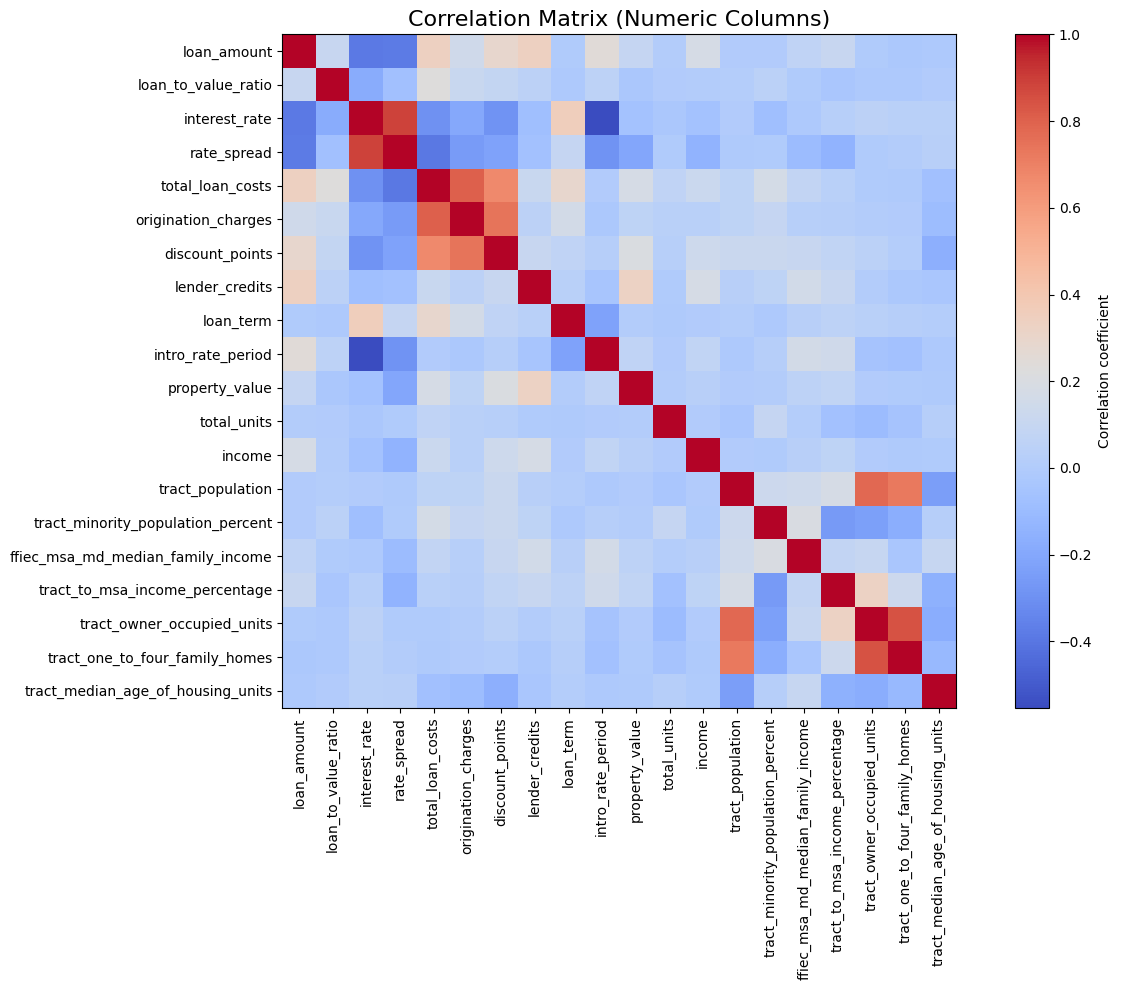

In [4]:
print("\n=== CORRELATION MATRIX (NUMERIC COLUMNS) ===")

# Convert numeric columns to proper numeric type (if not done already)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix (using Pearson by default)
corr_matrix = df[num_cols].corr(method='pearson')

# Display matrix
print(corr_matrix)

# Optional: show as heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.title("Correlation Matrix (Numeric Columns)", fontsize=16)
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()
